# Needle Insertion Markov Decision Process

In [1]:
using POMDPs
using Distributions
using POMDPToolbox
using PyPlot
using JLD
importall Base

## States

In [2]:
type NeedleState 
    x::Int64 # x position
    y::Int64 # y position
    psi::Int64 # orientation
    done::Bool # are we in a terminal state?
end

Below are some convenience functions for working with the NeedleState. 

In [3]:
# initial state constructor
NeedleState(x::Int64, y::Int64, psi::Int64) = NeedleState(x,y,psi,false)
# checks if the position of two states are the same
posequal(s1::NeedleState, s2::NeedleState) = s1.x == s2.x && s1.y == s2.y && s1.psi == s2.psi
# copies state s2 to s1
function Base.copy!(s1::NeedleState, s2::NeedleState) 
    s1.x = s2.x
    s1.y = s2.y
    s1.psi = s2.psi
    s1.done = s2.done
    s1
end

Base.hash(s::NeedleState, h::UInt64 = zero(UInt64)) = hash(s.x, hash(s.y, hash(s.psi, hash(s.done, h))))
Base.isequal(s1::NeedleState,s2::NeedleState) = (s1.x == s2.x && s1.y == s2.y && s1.psi == s2.psi && s1.done == s2.done);
==(s1::NeedleState, s2::NeedleState) = (s1.x == s2.x && s1.y == s2.y && s1.psi == s2.psi && s1.done == s2.done);

## POMDP

In [4]:
# the needle mdp type
type Needle <: POMDP{NeedleState, Symbol, NeedleState} # Note that our MDP is parametarized by the state and the action
    size_x::Int64 # x size of the grid
    size_y::Int64 # y size of the grid
    size_psi::Int64 # number of orientation bins
    reward_states::Vector{NeedleState} # target/obstacle states
    reward_values::Vector{Float64} # reward values for those states
    tprob::Array{Float64} # probability of transitioning to the desired state
    discount_factor::Float64 # disocunt factor
end

In [5]:
# we use key worded arguments so we can change any of the values we pass in 
function Needle(;sx::Int64 = 10, # size_x
                sy::Int64 = 10, # size_y
                spsi::Int64 = 8, # size_psi
                rs::Vector{NeedleState} = [[NeedleState(8,4,psi) for psi = 1:spsi]; # target states
                                            [NeedleState(4,6,psi) for psi = 1:spsi]; # obstacle states
                                            [NeedleState(1,y,psi) for y = 1:sy, psi = 3:7][:]; # boundary states
                                            [NeedleState(sx,y,psi) for y = 1:sy, psi = [1:3;7:spsi]][:];
                                            [NeedleState(x,1,psi) for x = 2:sx-1, psi = [5:spsi;1]][:];
                                            [NeedleState(x,sy,psi) for x = 2:sx-1, psi = 1:5][:]],
                rv::Vector{Float64} = [fill(100.0,spsi); fill(-20.0,spsi); fill(-5,(2*sx+2*sy-4)*5)],
                tp::Array{Float64} = [0.05, 0.9, 0.05, 0.0], # tprob
                discount_factor::Float64 = 0.9)
    return Needle(sx, sy, spsi, rs, rv, tp, discount_factor)
end

# we can now create a NeedleState mdp instance like this:
pomdp = Needle();
#pomdp.reward_states # mdp contains all the defualt values from the constructor

Needle(10,10,8,NeedleState[NeedleState(8,4,1,false),NeedleState(8,4,2,false),NeedleState(8,4,3,false),NeedleState(8,4,4,false),NeedleState(8,4,5,false),NeedleState(8,4,6,false),NeedleState(8,4,7,false),NeedleState(8,4,8,false),NeedleState(4,6,1,false),NeedleState(4,6,2,false)  …  NeedleState(8,10,4,false),NeedleState(9,10,4,false),NeedleState(2,10,5,false),NeedleState(3,10,5,false),NeedleState(4,10,5,false),NeedleState(5,10,5,false),NeedleState(6,10,5,false),NeedleState(7,10,5,false),NeedleState(8,10,5,false),NeedleState(9,10,5,false)],[100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,-20.0,-20.0  …  -5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0],[0.05,0.9,0.05,0.0],0.9)

## State Space ($ \mathcal{S}$) 

In [6]:
type StateSpace <: AbstractSpace
    states::Vector{NeedleState}
end

In [7]:
function POMDPs.states(pomdp::Needle)
    s = NeedleState[] # initialize an array of NeedleStates
    # loop over all our states, remeber there is one binary variables: done (d)
    for d = 0:1, y = 1:pomdp.size_y, x = 1:pomdp.size_x, psi = 1:pomdp.size_psi
        push!(s, NeedleState(x,y,psi,d))
    end
    return StateSpace(s)
end;

In [8]:
function POMDPs.iterator(space::StateSpace)
    return space.states 
end;

In [9]:
function POMDPs.rand(rng::AbstractRNG, space::StateSpace, s::NeedleState)
    sp = space.states[rand(rng, 1:end)]
    copy!(s, sp)
    return s
end;
POMDPs.rand(rng::AbstractRNG, space::StateSpace) = space.states[rand(rng, 1:end)];

## State Distribution

In [10]:
type NeedleDistribution <: AbstractDistribution
    neighbors::Array{NeedleState} # the states s' in the distribution
    probs::Array{Float64} # the probability corresponding to each state s'
    cat::Categorical # this comes from Distributions.jl and is used for sampling
end

In [11]:
function POMDPs.create_transition_distribution(pomdp::Needle)
    # can have at most five neighbors in grid world
    neighbors =  [NeedleState(i,i,1) for i = 1:5]
    probabilities = zeros(5) + 1.0/5.0
    cat = Categorical(5)
    return NeedleDistribution(neighbors, probabilities, cat)
end;

In [12]:
function POMDPs.iterator(d::NeedleDistribution)
    return d.neighbors
end;

In [13]:
function POMDPs.pdf(d::NeedleDistribution, s::NeedleState)
    for (i, sp) in enumerate(d.neighbors)
        if s == sp
            return d.probs[i]
        end
    end   
    return 0.0
end;

In [14]:
function POMDPs.rand(rng::AbstractRNG, d::NeedleDistribution, s::NeedleState)
    d.cat = Categorical(d.probs) # init the categorical distribution
    ns = d.neighbors[rand(d.cat)] # sample a neighbor state according to the distribution c
    copy!(s, ns)
    return s # return the pointer to s
end;

### Initial State Distribution

In [15]:
type InitialStateDistribution <: AbstractDistribution
    states::Array{NeedleState}
    probs::Array{Float64}
end
POMDPs.iterator(d::InitialStateDistribution) = d.states

In [16]:
function POMDPs.initial_state_distribution(pomdp::Needle)
    s = iterator(states(pomdp));
    ns = n_states(pomdp);
    p = zeros(ns)+1.0/ns;
    return InitialStateDistribution(s,p);
end

function POMDPs.initial_state_distribution(pomdp::Needle, state::NeedleState)
    s = [state];
    p = [1.0];
    return InitialStateDistribution(s,p);
end

In [17]:
function POMDPs.rand(rng::AbstractRNG, d::InitialStateDistribution, s::NeedleState)
    cat = Categorical(d.probs) # init the categorical distribution
    ns = d.states[rand(cat)] # sample a neighbor state according to the distribution c
    copy!(s, ns)
    return s # return the pointer to s
end;

In [18]:
function POMDPs.pdf(d::InitialStateDistribution, s::NeedleState)
    for (i, sp) in enumerate(d.states)
        if s == sp
            return d.probs[i]
        end
    end   
    return 0.0
end;

## Action Space ($\mathcal{A}$)

In [19]:
type ActionSpace <: AbstractSpace
    actions::Vector{Symbol}
end

In [20]:
function POMDPs.actions(pomdp::Needle)
    acts = [:cw, :ccw]
    return ActionSpace(acts)
end;
POMDPs.actions(pomdp::Needle, s::NeedleState, as::ActionSpace=actions(pomdp)) = as;

In [21]:
function POMDPs.iterator(space::ActionSpace)
    return space.actions 
end;

In [22]:
function POMDPs.rand(rng::AbstractRNG, space::ActionSpace, a::Symbol)
    return space.actions[rand(rng, 1:end)]
end;
function POMDPs.rand(rng::AbstractRNG, space::ActionSpace)
    a = NeedleAction(:cw)
    return rand(rng, space, a)
end;

## Observation Space ($\mathcal{O}$)

In [23]:
type ObservationSpace <: AbstractSpace
    obs::Vector{NeedleState}
end

In [24]:
function POMDPs.observations(pomdp::Needle)
    s = NeedleState[] # initialize an array of GridWorldStates
    # loop over all our states, remeber there are two binary variables:
    # done (d)
    for d=0:1, psi = 1: pomdp.size_psi, y = 1:pomdp.size_y, x = 1:pomdp.size_x
        push!(s, NeedleState(x,y,psi,d))
    end
    return ObservationSpace(s)
end;

POMDPs.observations(pomdp::Needle, s::NeedleState, obs::ObservationSpace=observations(pomdp)) = obs;

In [25]:
function POMDPs.iterator(space::ObservationSpace)
    return space.obs 
end;

## Observation Distribution

In [26]:
type ObsDistribution <: AbstractDistribution
    #curr_obs::NeedleState # the current observation
    neighbors::Array{NeedleState} # the states s' in the distribution
    probs::Array{Float64} # the probability corresponding to each state s'
    cat::Categorical # this comes from Distributions.jl and is used for sampling
end

In [27]:
function POMDPs.create_observation_distribution(pomdp::Needle)
    # 27 potential observations
    # initialize to whatever
    neighbors =  [NeedleState(i,j,k) for i = 1:3, j = 1:3, k = 1:3]
    probabilities = zeros(27) + 1.0/27.0
    cat = Categorical(27)
    return ObsDistribution(neighbors,probabilities,cat)
end;

In [28]:
function POMDPs.iterator(d::ObsDistribution)
    return d.neighbors # d.curr_obs
end;

In [29]:
function POMDPs.pdf(d::ObsDistribution, o::NeedleState)
    for (i, op) in enumerate(d.neighbors)
        if o == op
            return d.probs[i]
        end
    end   
    return 0.0
end

In [30]:
function POMDPs.rand(rng::AbstractRNG, d::ObsDistribution, o::NeedleState)
    d.cat = Categorical(d.probs) # init the categorical distribution
    no = d.neighbors[rand(d.cat)] # sample a neighbor state according to the distribution c
    copy!(o, no)
    return o # d.curr_obs
end
POMDPs.rand(rng::AbstractRNG, d::ObsDistribution) = rand(rng,d,NeedleState(1,1,1)) # d.curr_obs

## Transition Model (T)

In [23]:
# transition helpers
function inbounds(pomdp::Needle,x::Int64,y::Int64,psi::Int64)
    if 1 <= x <= pomdp.size_x && 1 <= y <= pomdp.size_y && 1 <= psi <= pomdp.size_psi
        return true
    else
        return false
    end
end

function inbounds(pomdp::Needle,state::NeedleState)
    x = state.x
    y = state.y
    psi = state.psi
    return inbounds(pomdp, x, y, psi)
end

###########################################################

function atbounds(pomdp::Needle,x::Int64,y::Int64,psi::Int64)
    # at bounds if: at wall, facing outward or at corner
    if (x == 1 || x == pomdp.size_x) && (y == 1 || y == pomdp.size_y) # at corner
        return true
        elseif (x == 1 && 3 <= psi <= 7) || (x == pomdp.size_x && (7 <= psi || psi <= 3) ) ||
        (y == 1 && (5 <= psi || psi <= 1) ) || (y == pomdp.size_y && 1 <= psi <= 5) # at wall, facing outward
        return true
    else
        return false
    end
end

function atbounds(pomdp::Needle,state::NeedleState)
    x = state.x
    y = state.y
    psi = state.psi
    return atbounds(pomdp, x, y, psi)
end

###########################################################

function fill_probability!(p::Vector{Float64}, val::Float64, index::Int64)
    for i = 1:length(p)
        if i == index
            p[i] = val
        else
            p[i] = 0.0
        end
    end
end;


In [24]:
function POMDPs.transition(pomdp::Needle,
                            state::NeedleState,
                            action::Symbol,
                            d::NeedleDistribution=create_transition_distribution(pomdp))
    tp = pomdp.tprob
    
    a = action
    x = state.x
    y = state.y
    psi = state.psi
    
    neighbors = d.neighbors
    probability = d.probs
    
    # let's handle the done case first
    if state.done
        # can only transition to the same done state
        fill!(probability, 0.0)
        probability[1] = 1.0
        copy!(neighbors[1], state)
        # when we sample d, we will only get the state in neighbors[1] - our done state
        return d
    end
    
    fill!(probability, 0.0)

    if a == :ccw
        if psi == 1
            neighbors[1].x = x+1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y;   neighbors[2].psi = psi+1;
            neighbors[3].x = x+1; neighbors[3].y = y+1; neighbors[3].psi = psi+1;
            neighbors[4].x = x+1; neighbors[4].y = y+1; neighbors[4].psi = psi+2;
        elseif psi == 2
            neighbors[1].x = x+1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y+1; neighbors[2].psi = psi+1;
            neighbors[3].x = x;   neighbors[3].y = y+1; neighbors[3].psi = psi+1;
            neighbors[4].x = x;   neighbors[4].y = y+1; neighbors[4].psi = psi+2;
        elseif psi == 3
            neighbors[1].x = x;   neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y+1; neighbors[2].psi = psi+1;
            neighbors[3].x = x-1; neighbors[3].y = y+1; neighbors[3].psi = psi+1;
            neighbors[4].x = x-1; neighbors[4].y = y+1; neighbors[4].psi = psi+2;
        elseif psi == 4
            neighbors[1].x = x-1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y+1; neighbors[2].psi = psi+1;
            neighbors[3].x = x-1; neighbors[3].y = y;   neighbors[3].psi = psi+1;
            neighbors[4].x = x-1; neighbors[4].y = y;   neighbors[4].psi = psi+2;
        elseif psi == 5
            neighbors[1].x = x-1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y;   neighbors[2].psi = psi+1;
            neighbors[3].x = x-1; neighbors[3].y = y-1; neighbors[3].psi = psi+1;
            neighbors[4].x = x-1; neighbors[4].y = y-1; neighbors[4].psi = psi+2;
        elseif psi == 6
            neighbors[1].x = x-1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y-1; neighbors[2].psi = psi+1;
            neighbors[3].x = x;   neighbors[3].y = y-1; neighbors[3].psi = psi+1;
            neighbors[4].x = x;   neighbors[4].y = y-1; neighbors[4].psi = psi+2;
        elseif psi == 7
            neighbors[1].x = x;   neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y-1; neighbors[2].psi = psi+1;
            neighbors[3].x = x+1; neighbors[3].y = y-1; neighbors[3].psi = psi+1;
            neighbors[4].x = x+1; neighbors[4].y = y-1; neighbors[4].psi = psi+2;
        elseif psi == 8
            neighbors[1].x = x+1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y-1; neighbors[2].psi = psi+1;
            neighbors[3].x = x+1; neighbors[3].y = y;   neighbors[3].psi = psi+1;
            neighbors[4].x = x+1; neighbors[4].y = y;   neighbors[4].psi = psi+2;
        end
    elseif a == :cw
        if psi == 1
            neighbors[1].x = x+1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y;   neighbors[2].psi = psi+7;
            neighbors[3].x = x+1; neighbors[3].y = y-1; neighbors[3].psi = psi+7;
            neighbors[4].x = x+1; neighbors[4].y = y-1; neighbors[4].psi = psi+6;
        elseif psi == 2
            neighbors[1].x = x+1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y+1; neighbors[2].psi = psi+7;
            neighbors[3].x = x+1; neighbors[3].y = y;   neighbors[3].psi = psi+7;
            neighbors[4].x = x+1; neighbors[4].y = y;   neighbors[4].psi = psi+6;
        elseif psi == 3
            neighbors[1].x = x;   neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y+1; neighbors[2].psi = psi+7;
            neighbors[3].x = x+1; neighbors[3].y = y+1; neighbors[3].psi = psi+7;
            neighbors[4].x = x+1; neighbors[4].y = y+1; neighbors[4].psi = psi+6;
        elseif psi == 4
            neighbors[1].x = x-1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y+1; neighbors[2].psi = psi+7;
            neighbors[3].x = x;   neighbors[3].y = y+1; neighbors[3].psi = psi+7;
            neighbors[4].x = x;   neighbors[4].y = y+1; neighbors[4].psi = psi+6;
        elseif psi == 5
            neighbors[1].x = x-1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y;   neighbors[2].psi = psi+7;
            neighbors[3].x = x-1; neighbors[3].y = y+1; neighbors[3].psi = psi+7;
            neighbors[4].x = x-1; neighbors[4].y = y+1; neighbors[4].psi = psi+6;
        elseif psi == 6
            neighbors[1].x = x-1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y-1; neighbors[2].psi = psi+7;
            neighbors[3].x = x-1; neighbors[3].y = y;   neighbors[3].psi = psi+7;
            neighbors[4].x = x-1; neighbors[4].y = y;   neighbors[4].psi = psi+6;
        elseif psi == 7
            neighbors[1].x = x;   neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y-1; neighbors[2].psi = psi+7;
            neighbors[3].x = x-1; neighbors[3].y = y-1; neighbors[3].psi = psi+7;
            neighbors[4].x = x-1; neighbors[4].y = y-1; neighbors[4].psi = psi+6;
        elseif psi == 8
            neighbors[1].x = x+1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y-1; neighbors[2].psi = psi+7;
            neighbors[3].x = x;   neighbors[3].y = y-1; neighbors[3].psi = psi+7;
            neighbors[4].x = x;   neighbors[4].y = y-1; neighbors[4].psi = psi+6;
        end
    end
    # make sure psi is between 1 and 8
    for i = 1:4
        neighbors[i].psi = mod(neighbors[i].psi,8)
        if neighbors[i].psi == 0
            neighbors[i].psi = 8;
        end
    end
    neighbors[5].x = x; neighbors[5].y = y; neighbors[5].psi = psi;
    
    # initialize done states 
    for i = 1:5 neighbors[i].done = false end
    reward_states = pomdp.reward_states
    
    # detection of done states
    n = length(reward_states)
    for i = 1:n
        # terminate at target/obstacle
        if posequal(state, reward_states[i])
            fill_probability!(probability, 1.0, 5)
            neighbors[5].done = true
            return d
        end
        # terminate at boundary
        if atbounds(pomdp, state)
            fill_probability!(probability, 1.0, 5)
            neighbors[5].done = true
            return d
        end
    end
    
    if !inbounds(pomdp, neighbors[1]) || !inbounds(pomdp, neighbors[2]) ||
        !inbounds(pomdp, neighbors[3]) || !inbounds(pomdp, neighbors[4]) # at least one of the neighbors is outside bounds
        fill_probability!(probability, 1.0, 5) # stuck in current state when terminated
    else # none of the neighbors is outside bounds
        probability[1:4] = tp
    end
    
    return d
end;

## Observation Model

In [33]:
function POMDPs.observation(pomdp::Needle,
                           action::Symbol,
                           state::NeedleState,
                           d::NeedleObservationDistribution=create_observation_distribution(pomdp))
    a = action
    x = state.x
    y = state.y
    psi = state.psi
    
    neighbor = d.neighbors
    probability = d.probs
    
    neighbor[1].x = x; neighbor[1].y = y; neighbor[1].psi = psi
    neighbor[2].x = x; neighbor[2].y = y; neighbor[2].psi = psi+1
    neighbor[3].x = x; neighbor[3].y = y; neighbor[3].psi = psi-1
    
    neighbor[4].x = x+1; neighbor[4].y = y; neighbor[4].psi = psi
    neighbor[5].x = x+1; neighbor[5].y = y; neighbor[5].psi = psi+1
    neighbor[6].x = x+1; neighbor[6].y = y; neighbor[6].psi = psi-1
    
    neighbor[7].x = x; neighbor[7].y = y+1; neighbor[7].psi = psi
    neighbor[8].x = x; neighbor[8].y = y+1; neighbor[8].psi = psi+1
    neighbor[9].x = x; neighbor[9].y = y+1; neighbor[9].psi = psi-1
    
    neighbor[10].x = x+1; neighbor[10].y = y+1; neighbor[10].psi = psi
    neighbor[11].x = x+1; neighbor[11].y = y+1; neighbor[11].psi = psi+1
    neighbor[12].x = x+1; neighbor[12].y = y+1; neighbor[12].psi = psi-1

    neighbor[13].x = x-1; neighbor[13].y = y; neighbor[13].psi = psi
    neighbor[14].x = x-1; neighbor[14].y = y; neighbor[14].psi = psi+1
    neighbor[15].x = x-1; neighbor[15].y = y; neighbor[15].psi = psi-1
    
    neighbor[16].x = x; neighbor[16].y = y-1; neighbor[16].psi = psi
    neighbor[17].x = x; neighbor[17].y = y-1; neighbor[17].psi = psi+1
    neighbor[18].x = x; neighbor[18].y = y-1; neighbor[18].psi = psi-1
    
    neighbor[19].x = x-1; neighbor[19].y = y-1; neighbor[19].psi = psi
    neighbor[20].x = x-1; neighbor[20].y = y-1; neighbor[20].psi = psi+1
    neighbor[21].x = x-1; neighbor[21].y = y-1; neighbor[21].psi = psi-1
    
    neighbor[22].x = x-1; neighbor[22].y = y+1; neighbor[22].psi = psi
    neighbor[23].x = x-1; neighbor[23].y = y+1; neighbor[23].psi = psi+1
    neighbor[24].x = x-1; neighbor[24].y = y+1; neighbor[24].psi = psi-1
    
    neighbor[25].x = x+1; neighbor[25].y = y-1; neighbor[25].psi = psi
    neighbor[26].x = x+1; neighbor[26].y = y-1; neighbor[26].psi = psi+1
    neighbor[27].x = x+1; neighbor[27].y = y-1; neighbor[27].psi = psi-1
    
    probability=[0.36,0.12,0.12,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01,0.03,0.01,0.01];
    
#     d.curr_obs = NeedleState(x, y, psi);
    return d
end

POMDPs.observation(pomdp::Needle,
                   state::NeedleState,
                   action::Symbol,
                   sp::NeedleState,
                    d::ObsDistribution = create_observation_distribution(pomdp)) = observation(pomdp, action, sp, d);

LoadError: LoadError: UndefVarError: ObsDistribution not defined
while loading In[33], in expression starting on line 51

## Reward Model (R)

In [34]:
function POMDPs.reward(pomdp::Needle, state::NeedleState, action::Symbol) #deleted action
    if state.done
        return 0.0
    end
    r = 0.0
    reward_states = pomdp.reward_states
    reward_values = pomdp.reward_values
    n = length(reward_states)
    for i = 1:n
        if posequal(state, reward_states[i]) # reward, obstacle and wall states
            r += reward_values[i]
        end
    end
    r += -1; # penalty for every step taken
    return r
end;

## Miscellaneous functions

In [35]:
POMDPs.n_states(pomdp::Needle) = 2*pomdp.size_x*pomdp.size_y*pomdp.size_psi
POMDPs.n_actions(pomdp::Needle) = 2;
POMDPs.n_observations(pomdp::Needle) = 2*pomdp.size_x*pomdp.size_y*pomdp.size_psi;
POMDPs.discount(pomdp::Needle) = pomdp.discount_factor;

In [36]:
function POMDPs.state_index(pomdp::Needle, state::NeedleState)
    sd = Int(state.done + 1)
    return sub2ind((pomdp.size_x, pomdp.size_y, pomdp.size_psi, 2, 2), state.x, state.y, state.psi, sd)
end;

In [37]:
function POMDPs.isterminal(pomdp::Needle, s::NeedleState)
    s.done ? (return true) : (return false)
end;

In [38]:
POMDPs.create_state(pomdp::Needle) = NeedleState(1,1,1)
POMDPs.create_action(pomdp::Needle) = :cw;
POMDPs.create_observation(pomd::Needle) = NeedleState(1,1,1)

## SARSOP Solver
Resolve policy if you made a significant change

In [ ]:
# using SARSOP # load the module
# # initialize our tiger POMDP
# pomdp = Needle()

# # initialize the solver
# solver = SARSOPSolver(timeout=300.0) # 5 min
# # run the solve function
# policy = solve(solver, pomdp)

In [40]:
using SARSOP
filename = "SARSOP policy"
policy = JLD.load(string(filename,".jld"), "policy")

SARSOP.POMDPPolicy("out.policy",POMDPXFiles.POMDPAlphas([-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0,1,1,0,0,1,1,0,1,0  …  0,0,0,0,0,0,0,0,1,1]),Needle(10,10,8,NeedleState[NeedleState(8,4,1,false),NeedleState(8,4,2,false),NeedleState(8,4,3,false),NeedleState(8,4,4,false),NeedleState(8,4,5,false),NeedleState(8,4,6,false),NeedleState(8,4,7,false),NeedleState(8,4,8,false),NeedleState(4,6,1,false),NeedleState(4,6,2,false)  …  NeedleState(8,10,4,false),NeedleState(9,10,4,false),NeedleState(2,10,5,false),NeedleState(3,10,5,false),NeedleState(4,10,5,false),NeedleState(5,10,5,false),NeedleState(6,10,5,false),NeedleState(7,10,5,false),NeedleState(8,10,5,false),NeedleState(9,10,5,false)],[100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,-20.0,-20.0  …  -5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0],[0.05,0.9,0.05,0.0],0.9),Any[:cw,:ccw])

## Simulation

In [71]:

init_state = initial_state_distribution(pomdp, NeedleState(4,10,7))
hist_SARSOP = HistoryRecorder(max_steps=100)
r = simulate(hist_SARSOP, pomdp, policy, updater(policy), init_state)



Invalid update for: POMDPToolbox.DiscreteBelief([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
using POMDPToolbox

init_state = initial_state_distribution(pomdp, NeedleState(4,10,7))
hist_SARSOP = HistoryRecorder(max_steps=100)
r = simulate(hist_SARSOP, pomdp, policy, updater(policy), init_state)

println("Total discounted reward: $r")

if hist_SARSOP.state_hist[end].x == pomdp.reward_states[1].x && hist_SARSOP.state_hist[end].y == pomdp.reward_states[1].y
    println("Target reached")
else
    println("Target missed")
end

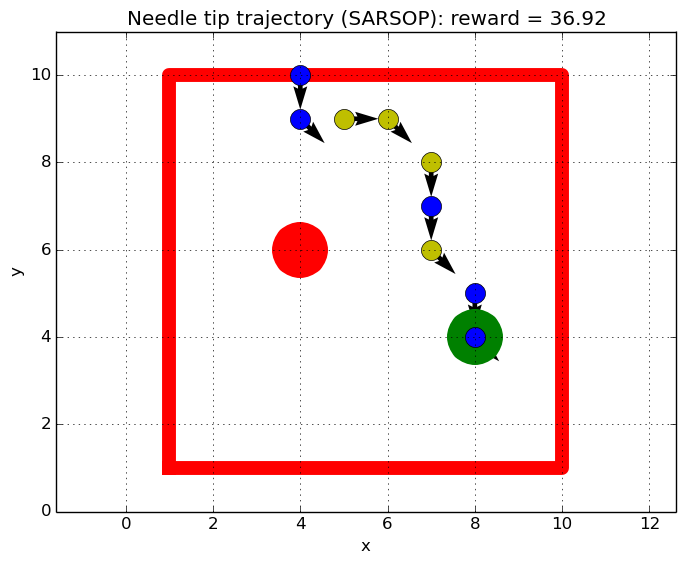

In [72]:
# define tissue environment
plot([1 10 10 1 1]',[1 1 10 10 1]',linewidth=10,color="r") # tissue bounds
plot(pomdp.reward_states[1].x,pomdp.reward_states[1].y,marker="o",markersize=40,color="g",markeredgecolor="none")
plot(pomdp.reward_states[9].x,pomdp.reward_states[9].y,marker="o",markersize=40,color="r",markeredgecolor="none")

# needle trajectory
steps = length(hist_SARSOP.state_hist)
for i = 1:steps-1 
    state = hist_SARSOP.state_hist[i]
    action = hist_SARSOP.action_hist[i]
    if action == :cw
        c = "y"
    else
        c = "b"
    end
    plot(state.x,state.y,color=c,marker="o",markersize=15)
    quiver(state.x,state.y,0.5*cos((state.psi-1)*pi/4),0.5*sin((state.psi-1)*pi/4))
end

title(@sprintf("Needle tip trajectory (SARSOP): reward = %0.2f",r))
axis("equal")
axis([0, 11, 0, 11])
xlabel("x")
ylabel("y")
grid(true)

savefig("SARSOP plot")

In [43]:
# # save the policy
# filename = "SARSOP policy"
# JLD.save(string(filename,".jld"),"policy",policy)

In [ ]:
init_state = initial_state_distribution(pomdp, NeedleState(4,10,7))

In [ ]:
using DiscreteValueIteration

# initialize the problem
mdp = Needle()

# initialize the solver
# max_iterations: maximum number of iterations value iteration runs for (default is 100)
# belres: the value of Bellman residual used in the solver (defualt is 1e-3)
solver = ValueIterationSolver(max_iterations=100, belres=1e-3)

# initialize the policy by passing in your problem
policy_vi = ValueIterationPolicy(mdp)

# solve for an optimal policy
# if verbose=false, the text output will be supressed (false by default)
solve(solver, mdp, policy_vi, verbose=true);

## Monte-Carlo Tree Search Solver
Monte-Carlo Tree Search (MCTS) is another MDP solver. It is an online method that looks for the best action from only the current state by building a search tree.

In [ ]:
using MCTS

# initialize the problem
mdp = Needle()

# initialize the solver
# the hyper parameters in MCTS can be tricky to set properly
# n_iterations: the number of iterations that each search runs for
# depth: the depth of the tree (how far away from the current state the algorithm explores)
# exploration constant: this is how much weight to put into exploratory actions. 
# A good rule of thumb is to set the exploration constant to what you expect the upper bound on your average expected reward to be.
solver = MCTSSolver(n_iterations=100, depth=10, exploration_constant=1.0)

# initialize the policy by passing in your problem and the solver
policy_MCTS = MCTSPolicy(solver, mdp);

## Simulation

In [ ]:
s = NeedleState(4,10,7)
hist_vi = HistoryRecorder()

r = simulate(hist_vi, mdp, policy_vi, s)

println("Total discounted reward: $r")

if hist_MCTS.state_hist[end].x == mdp.reward_states[1].x && hist_MCTS.state_hist[end].y == mdp.reward_states[1].y
    println("Target reached")
else
    println("Target missed")
end

# define tissue environment
plot([1 10 10 1 1]',[1 1 10 10 1]',linewidth=10,color="r") # tissue bounds
plot(mdp.reward_states[1].x,mdp.reward_states[1].y,marker="o",markersize=40,color="g",markeredgecolor="none")
plot(mdp.reward_states[9].x,mdp.reward_states[9].y,marker="o",markersize=40,color="r",markeredgecolor="none")
hold(true)

for state in hist_vi.state_hist
    plot(state.x,state.y,color="b",marker="o")
    quiver(state.x,state.y,0.5*cos((state.psi-1)*pi/4),0.5*sin((state.psi-1)*pi/4))
end

title("Needle tip trajectory (value iteration)")
axis("equal")
axis([0, 11, 0, 11])
xlabel("x")
ylabel("y")
grid(true)

In [ ]:
s = NeedleState(4,10,7)

hist_MCTS = HistoryRecorder()
r = simulate(hist_MCTS, mdp, policy_MCTS, s)

println("Total discounted reward: $r")

if hist_MCTS.state_hist[end].x == mdp.reward_states[1].x && hist_MCTS.state_hist[end].y == mdp.reward_states[1].y
    println("Target reached")
else
    println("Target missed")
end

# define tissue environment
plot([1 10 10 1 1]',[1 1 10 10 1]',linewidth=10,color="r") # tissue bounds
plot(mdp.reward_states[1].x,mdp.reward_states[1].y,marker="o",markersize=40,color="g",markeredgecolor="none")
plot(mdp.reward_states[9].x,mdp.reward_states[9].y,marker="o",markersize=40,color="r",markeredgecolor="none")
hold(true)

for state in hist_MCTS.state_hist
    plot(state.x,state.y,color="b",marker="o")
    quiver(state.x,state.y,0.5*cos((state.psi-1)*pi/4),0.5*sin((state.psi-1)*pi/4))
end

title("Needle tip trajectory (MCTS)")
axis("equal")
axis([0, 11, 0, 11])
xlabel("x")
ylabel("y")
grid(true)

In [ ]:
# N = 100000
# r_all = ones(1,N)
# for i = 1:N
#     r_all[i] = simulate(hist_vi, mdp, policy_vi, s)
# end
# println(value(policy_vi, s))
# mean(r_all)